### **Import Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pygam import LinearGAM, s
import logging
import plotly.express as px
import matplotlib.pyplot as plt
# Matikan logger pygam agar output tidak terlalu banyak
logging.getLogger('pygam').setLevel(logging.WARNING)

### **Import Data Hasil Rules**

In [2]:
df = pd.read_csv('D:/kuliah/PA/sakinah-mart/data/rules2024.csv')
df.head()

,Unnamed: 0,antecedents,consequents,support,confidence,lift
0,0,"frozenset({'SAKINAH 1500ML', 'GREENFIELDS COKL...",frozenset({'GREENFIELDS STRAW 105ML'}),0.000109,1,4922.846154
1,1,"frozenset({'BISKUAT BOLU CKL 16GR', 'INDOMILK ...","frozenset({'INDOMILK KID VNL 115ML', 'CLOUD 9 ...",0.000141,1,2206.793103
2,2,"frozenset({'GATSBY SPL/C GS 175ML', 'FRESHCARE...",frozenset({'GATSBY SPL/C DO 175ML'}),0.000141,1,1185.129630
3,3,"frozenset({'KISPRAY POUCH GLAM/GLD 300ML', 'IN...",frozenset({'SOKLIN LIQ LAVENDER 625ML'}),0.000109,1,831.129870
4,4,"frozenset({'SEDAAP MIE CUP BASO BLEDUK', 'SEDA...",frozenset({'SEDAAP MIE CUP SOTO'}),0.000125,1,780.451220


In [3]:
# Pastikan semua elemen dalam kolom antecedents dan consequents adalah frozenset
df["antecedents"] = df["antecedents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)
df["consequents"] = df["consequents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)

# Mengambil semua item unik
all_items = set()
for col in ["antecedents", "consequents"]:
    for items in df[col]:
        all_items.update(items)

all_items

{'ADEM SARI CHINGKU MD LMN 350ML',
 'ATTACK JAZ 1 CINTA 1 6 KG',
 'BISKUAT BOLU CKL 16GR',
 'CLOUD 9 CHOCO 15 4G',
 'CLOUD 9 VANILA 15 4G',
 'DAIA LEMON 65GR',
 'DELFI TOP B/WHITE 9GR',
 'DELFI TOP CHO 9GR',
 'DELFI TOP STR 9GR',
 'DELFI TOP TRIP/CHO 9GR',
 'EKONOMI LIQUID REFF 235ML',
 'FRESHCARE ORIGINAL 10ML',
 'GATSBY SPL/C DO 175ML',
 'GATSBY SPL/C GS 175ML',
 'GREENFIELDS COKLAT 105ML',
 'GREENFIELDS STRAW 105ML',
 'INDOMIE GRG SPECIAL',
 'INDOMIE RAMEN TORI KARA/20',
 'INDOMIE SOTO MIE',
 'INDOMILK KID CKL 115ML',
 'INDOMILK KID STR 115ML',
 'INDOMILK KID VNL 115ML',
 'KISPRAY POUCH GLAM/GLD 300ML',
 'MAMA LEMON 115ML',
 'MOMOGI JGG BKR 6GR',
 'MR POTATO CRIPS ORI 35G',
 'NEXTAR BROWNIES 42GR',
 'NEXTAR PINEAPLE 112G',
 'NUVO SOAP BLUE 72G',
 'NUVO SOAP RED 72G',
 'ROMA KELAPA 300GR',
 'SAKINAH 1500ML',
 'SEDAAP MIE AYAM BWG',
 'SEDAAP MIE CUP AYM JERIT /12',
 'SEDAAP MIE CUP BASO BLEDUK',
 'SEDAAP MIE CUP BASO SPC',
 'SEDAAP MIE CUP KARE',
 'SEDAAP MIE CUP SOTO',
 'SEDAAP MIE S

### **Import Data Transaksi**

In [4]:
groceries = pd.read_excel('D:/kuliah/PA/sakinah-mart/data/final_data2024.xlsx')
groceries

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
0,2024-01-01,2401011010001,GULA ROSE BRAND 1KG,1
1,2024-01-01,2401011010002,RIZKI MG 850ML/900ML BTL,3
2,2024-01-01,2401011010003,ULTRA MIMI VNL 125ML,1
3,2024-01-01,2401011010003,BEAR BRAND 189ML,1
4,2024-01-01,2401011010003,TINI WINI BITI ASIN 20 GR,1
...,...,...,...,...
167618,2024-12-31,2412311020122,WALLS POPULAIRE CKL,1
167619,2024-12-31,2412311020123,THERMAL 80X50 TRUST PAPER,1
167620,2024-12-31,2412311020124,SAKINAH 600ML,1
167621,2024-12-31,2412311020124,WALLS PP RAINBOW P,1


### **Filter Data Transaksi**

In [5]:
df_filtered = groceries[groceries['NAMA BARANG'].isin(all_items)]
df_filtered 

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
20,2024-01-01,2401011010011,INDOMIE GRG SPECIAL,1
32,2024-01-01,2401011010015,EKONOMI LIQUID REFF 235ML,1
55,2024-01-01,2401011010017,ROMA KELAPA 300GR,1
59,2024-01-01,2401011010018,INDOMILK KID VNL 115ML,1
73,2024-01-01,2401011010023,ROMA KELAPA 300GR,1
...,...,...,...,...
167537,2024-12-31,2412311020090,INDOMILK KID CKL 115ML,1
167552,2024-12-31,2412311020096,INDOMIE RAMEN TORI KARA/20,1
167607,2024-12-31,2412311020118,INDOMILK KID STR 115ML,1
167608,2024-12-31,2412311020118,INDOMILK KID VNL 115ML,1


In [6]:
# Menampilkan jumlah unik nama barang
jumlah_nama_barang = df_filtered['NAMA BARANG'].nunique()
print("Jumlah nama barang unik:", jumlah_nama_barang)

# Menampilkan isi nama barang yang unik
nama_barang_unik = df_filtered['NAMA BARANG'].unique()
print("Nama barang unik:")
for nama in nama_barang_unik:
    print("-", nama)

Jumlah nama barang unik: 45
Nama barang unik:
- INDOMIE GRG SPECIAL
- EKONOMI LIQUID REFF 235ML
- ROMA KELAPA 300GR
- INDOMILK KID VNL 115ML
- SEDAAP MIE AYAM BWG
- SEDAAP MIE SOTO
- ATTACK JAZ 1 CINTA 1 6 KG
- WALLS POPULAIRE CKL
- MAMA LEMON 115ML
- WALLS CORN STRW VANILA
- DELFI TOP CHO 9GR
- DELFI TOP STR 9GR
- DELFI TOP B/WHITE 9GR
- SEDAAP MIE CUP SOTO
- SEDAAP MIE CUP KARE
- DELFI TOP TRIP/CHO 9GR
- DAIA LEMON 65GR
- NUVO SOAP RED 72G
- NUVO SOAP BLUE 72G
- SEDAAP MIE CUP AYM JERIT /12
- SEDAAP MIE CUP BASO BLEDUK
- WALLS CORN B/WHITE 82GR
- BISKUAT BOLU CKL 16GR
- INDOMIE SOTO MIE
- SOKLIN LIQ LAVENDER 625ML
- INDOMILK KID STR 115ML
- WALLS POPULAIRE STR
- SAKINAH 1500ML
- KISPRAY POUCH GLAM/GLD 300ML
- MR POTATO CRIPS ORI 35G
- INDOMILK KID CKL 115ML
- GATSBY SPL/C DO 175ML
- GATSBY SPL/C GS 175ML
- FRESHCARE ORIGINAL 10ML
- INDOMIE RAMEN TORI KARA/20
- NEXTAR BROWNIES 42GR
- CLOUD 9 VANILA 15 4G
- TEH GELAS ORI 170ML
- CLOUD 9 CHOCO 15 4G
- NEXTAR PINEAPLE 112G
- SEDAAP MIE C

### **Agregasi Data Mingguan**

In [7]:
# Agregasi jumlah QTY per tanggal dan nama barang
df_grouped = df_filtered.groupby(['TANGGAL', 'NAMA BARANG'], as_index=False)['QTY'].sum()

tanggal_range = pd.date_range(start='2024-01-01', end='2024-12-31')
all_items = df_filtered['NAMA BARANG'].unique()

# Buat kombinasi semua tanggal dan item
multi_index = pd.MultiIndex.from_product([tanggal_range, all_items], names=['TANGGAL', 'NAMA BARANG'])
all_combinations = pd.DataFrame(index=multi_index).reset_index()

# Gabungkan dengan hasil groupby
df_joined = pd.merge(all_combinations, df_grouped, on=['TANGGAL', 'NAMA BARANG'], how='left')
df_joined['QTY'] = df_joined['QTY'].fillna(0)

# Pastikan TANGGAL dalam datetime
df_joined['TANGGAL'] = pd.to_datetime(df_joined['TANGGAL'])

# Urutkan dulu datanya
df_joined = df_joined.sort_values('TANGGAL')

# Ambil tanggal paling awal
start_date = df_joined['TANGGAL'].min()

# Hitung minggu ke-n secara manual (tiap 7 hari)
df_joined['WEEK_NUMBER'] = ((df_joined['TANGGAL'] - start_date).dt.days // 7) + 1

# Agregasi berdasarkan minggu dan nama barang
df_weekly = df_joined.groupby(['WEEK_NUMBER', 'NAMA BARANG'], as_index=False)['QTY'].sum()

# (Opsional) Tambahkan kolom tanggal mulai minggu
df_weekly['TANGGAL'] = start_date + pd.to_timedelta((df_weekly['WEEK_NUMBER'] - 1) * 7, unit='D')

# Visualisasi
fig = px.line(df_weekly, x='TANGGAL', y='QTY', color='NAMA BARANG',
              title='Jumlah Penjualan per Minggu (Setiap 7 Hari)')
fig.update_layout(legend_title_text='Klik untuk tampilkan/sembunyikan item')
fig.show()

In [8]:
df_weekly

,WEEK_NUMBER,NAMA BARANG,QTY,TANGGAL
0,1,ADEM SARI CHINGKU MD LMN 350ML,0.0,2024-01-01
1,1,ATTACK JAZ 1 CINTA 1 6 KG,10.0,2024-01-01
2,1,BISKUAT BOLU CKL 16GR,5.0,2024-01-01
3,1,CLOUD 9 CHOCO 15 4G,3.0,2024-01-01
4,1,CLOUD 9 VANILA 15 4G,4.0,2024-01-01
...,...,...,...,...
2380,53,TEH GELAS ORI 170ML,0.0,2024-12-30
2381,53,WALLS CORN B/WHITE 82GR,0.0,2024-12-30
2382,53,WALLS CORN STRW VANILA,0.0,2024-12-30
2383,53,WALLS POPULAIRE CKL,9.0,2024-12-30


### **Pivot Data**

In [9]:
df_pivoted= df_weekly.pivot(index='TANGGAL', columns='NAMA BARANG', values='QTY')
df_pivoted.columns.name = None  # hilangkan nama kolom atas
df_pivoted = df_pivoted.reset_index() 
df_pivoted.head()

,TANGGAL,ADEM SARI CHINGKU MD LMN 350ML,ATTACK JAZ 1 CINTA 1 6 KG,BISKUAT BOLU CKL 16GR,CLOUD 9 CHOCO 15 4G,CLOUD 9 VANILA 15 4G,DAIA LEMON 65GR,DELFI TOP B/WHITE 9GR,DELFI TOP CHO 9GR,DELFI TOP STR 9GR,...,SEDAAP MIE CUP BASO SPC,SEDAAP MIE CUP KARE,SEDAAP MIE CUP SOTO,SEDAAP MIE SOTO,SOKLIN LIQ LAVENDER 625ML,TEH GELAS ORI 170ML,WALLS CORN B/WHITE 82GR,WALLS CORN STRW VANILA,WALLS POPULAIRE CKL,WALLS POPULAIRE STR
0,2024-01-01,0.0,10.0,5.0,3.0,4.0,5.0,6.0,8.0,5.0,...,0.0,2.0,5.0,38.0,2.0,3.0,17.0,2.0,10.0,4.0
1,2024-01-08,10.0,0.0,4.0,7.0,1.0,2.0,7.0,4.0,4.0,...,2.0,3.0,1.0,16.0,2.0,5.0,12.0,4.0,3.0,4.0
2,2024-01-15,8.0,0.0,7.0,5.0,7.0,0.0,3.0,1.0,3.0,...,2.0,3.0,2.0,20.0,0.0,4.0,3.0,0.0,7.0,7.0
3,2024-01-22,2.0,1.0,5.0,5.0,7.0,2.0,4.0,2.0,0.0,...,2.0,2.0,0.0,32.0,1.0,10.0,22.0,5.0,7.0,6.0
4,2024-01-29,0.0,5.0,0.0,10.0,7.0,3.0,9.0,10.0,5.0,...,2.0,0.0,2.0,16.0,2.0,9.0,8.0,2.0,8.0,5.0


In [10]:
# 1. Pisahkan kolom tanggal dan kolom produk
produk_df = df_pivoted.drop(columns=["TANGGAL"])

# 2. Hitung jumlah 0 per kolom
zero_counts = (produk_df == 0).sum()

# 3. Ambil item yang jumlah 0-nya <= 5
filtered_items = zero_counts[zero_counts <= 5].index

# 4. Filter dataframe hanya dengan item yang lolos kriteria 0
filtered_df = produk_df[filtered_items]

# 5. Hitung total penjualan per item
total_sales = filtered_df.sum().sort_values(ascending=False).index

# 6. Ambil 15 item dengan total penjualan tertinggi
# top_3_items = total_sales.head(15).index

# 7. Final dataframe dengan 15 item terbaik
df_final = df_pivoted[["TANGGAL"] + total_sales.tolist()]

In [11]:
df_final.head()

,TANGGAL,INDOMIE GRG SPECIAL,INDOMILK KID CKL 115ML,SEDAAP MIE SOTO,SAKINAH 1500ML,INDOMILK KID VNL 115ML,INDOMILK KID STR 115ML,INDOMIE SOTO MIE,SEDAAP MIE AYAM BWG,EKONOMI LIQUID REFF 235ML,WALLS CORN B/WHITE 82GR,WALLS POPULAIRE CKL,WALLS POPULAIRE STR,MAMA LEMON 115ML,DELFI TOP CHO 9GR,ROMA KELAPA 300GR,DELFI TOP B/WHITE 9GR,BISKUAT BOLU CKL 16GR,DELFI TOP STR 9GR
0,2024-01-01,129.0,3.0,38.0,6.0,8.0,3.0,18.0,14.0,9.0,17.0,10.0,4.0,3.0,8.0,12.0,6.0,5.0,5.0
1,2024-01-08,119.0,12.0,16.0,6.0,13.0,14.0,13.0,1.0,6.0,12.0,3.0,4.0,6.0,4.0,8.0,7.0,4.0,4.0
2,2024-01-15,88.0,13.0,20.0,5.0,10.0,10.0,16.0,9.0,4.0,3.0,7.0,7.0,7.0,1.0,6.0,3.0,7.0,3.0
3,2024-01-22,147.0,18.0,32.0,8.0,14.0,16.0,19.0,3.0,6.0,22.0,7.0,6.0,8.0,2.0,3.0,4.0,5.0,0.0
4,2024-01-29,114.0,20.0,16.0,4.0,19.0,22.0,15.0,5.0,11.0,8.0,8.0,5.0,7.0,10.0,6.0,9.0,0.0,5.0


In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   TANGGAL                    53 non-null     datetime64[ns]
 1   INDOMIE GRG SPECIAL        53 non-null     float64       
 2   INDOMILK KID CKL 115ML     53 non-null     float64       
 3   SEDAAP MIE SOTO            53 non-null     float64       
 4   SAKINAH 1500ML             53 non-null     float64       
 5   INDOMILK KID VNL 115ML     53 non-null     float64       
 6   INDOMILK KID STR 115ML     53 non-null     float64       
 7   INDOMIE SOTO MIE           53 non-null     float64       
 8   SEDAAP MIE AYAM BWG        53 non-null     float64       
 9   EKONOMI LIQUID REFF 235ML  53 non-null     float64       
 10  WALLS CORN B/WHITE 82GR    53 non-null     float64       
 11  WALLS POPULAIRE CKL        53 non-null     float64       
 12  WALLS POPU

In [13]:
# Ubah kolom TANGGAL menjadi datetime
df_final["TANGGAL"] = pd.to_datetime(df_final["TANGGAL"])

# Ubah dari wide ke long format agar cocok untuk plotly express
df_long = df_final.melt(id_vars="TANGGAL", var_name="NAMA BARANG", value_name="QTY")

# Buat line chart
fig = px.line(
    df_long,
    x="TANGGAL",
    y="QTY",
    color="NAMA BARANG",
    title="Jumlah Penjualan per Minggu per Item",
    markers=True,
    labels={"TANGGAL": "Tanggal", "QTY": "Jumlah Terjual", "NAMA BARANG": "Nama Produk"},
    hover_data={"TANGGAL": True, "QTY": True, "NAMA BARANG": True}
)

# Layout tambahan
fig.update_layout(
    legend_title_text='Klik nama produk untuk tampilkan/sembunyikan',
    xaxis_title='Tanggal',
    yaxis_title='Jumlah Terjual',
    template='plotly_white',
    height=500,
    width=900
)

fig.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13824\2313548066.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   TANGGAL                    53 non-null     datetime64[ns]
 1   INDOMIE GRG SPECIAL        53 non-null     float64       
 2   INDOMILK KID CKL 115ML     53 non-null     float64       
 3   SEDAAP MIE SOTO            53 non-null     float64       
 4   SAKINAH 1500ML             53 non-null     float64       
 5   INDOMILK KID VNL 115ML     53 non-null     float64       
 6   INDOMILK KID STR 115ML     53 non-null     float64       
 7   INDOMIE SOTO MIE           53 non-null     float64       
 8   SEDAAP MIE AYAM BWG        53 non-null     float64       
 9   EKONOMI LIQUID REFF 235ML  53 non-null     float64       
 10  WALLS CORN B/WHITE 82GR    53 non-null     float64       
 11  WALLS POPULAIRE CKL        53 non-null     float64       
 12  WALLS POPU

In [15]:
# Mengubah kolom TANGGAL menjadi datetime dan menjadikannya index
df_final['TANGGAL'] = pd.to_datetime(df_final['TANGGAL'])
df_final= df_final.set_index('TANGGAL')
df_final = df_final.asfreq('W-MON') # Menetapkan frekuensi mingguan (Senin)

df_final.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13824\815929434.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,INDOMIE GRG SPECIAL,INDOMILK KID CKL 115ML,SEDAAP MIE SOTO,SAKINAH 1500ML,INDOMILK KID VNL 115ML,INDOMILK KID STR 115ML,INDOMIE SOTO MIE,SEDAAP MIE AYAM BWG,EKONOMI LIQUID REFF 235ML,WALLS CORN B/WHITE 82GR,WALLS POPULAIRE CKL,WALLS POPULAIRE STR,MAMA LEMON 115ML,DELFI TOP CHO 9GR,ROMA KELAPA 300GR,DELFI TOP B/WHITE 9GR,BISKUAT BOLU CKL 16GR,DELFI TOP STR 9GR
TANGGAL,,,,,,,,,,,,,,,,,,
2024-01-01,129.0,3.0,38.0,6.0,8.0,3.0,18.0,14.0,9.0,17.0,10.0,4.0,3.0,8.0,12.0,6.0,5.0,5.0
2024-01-08,119.0,12.0,16.0,6.0,13.0,14.0,13.0,1.0,6.0,12.0,3.0,4.0,6.0,4.0,8.0,7.0,4.0,4.0
2024-01-15,88.0,13.0,20.0,5.0,10.0,10.0,16.0,9.0,4.0,3.0,7.0,7.0,7.0,1.0,6.0,3.0,7.0,3.0
2024-01-22,147.0,18.0,32.0,8.0,14.0,16.0,19.0,3.0,6.0,22.0,7.0,6.0,8.0,2.0,3.0,4.0,5.0,0.0
2024-01-29,114.0,20.0,16.0,4.0,19.0,22.0,15.0,5.0,11.0,8.0,8.0,5.0,7.0,10.0,6.0,9.0,0.0,5.0


In [16]:
# --- Pra-Pemrosesan Data ---
# 1. Mengubah index 'TANGGAL' menjadi kolom biasa (jika TANGGAL adalah index)
if df_final.index.name == 'TANGGAL':
    df_final = df_final.reset_index()
    df_final.rename(columns={'index': 'TANGGAL'}, inplace=True)
elif 'TANGGAL' not in df_final.columns:
    df_final = df_final.reset_index()
    df_final.rename(columns={df_final.columns[0]: 'TANGGAL'}, inplace=True)

# 2. Pastikan kolom 'TANGGAL' adalah tipe datetime
df_final['TANGGAL'] = pd.to_datetime(df_final['TANGGAL'])

# 3. Identifikasi kolom produk
product_columns = [col for col in df_final.columns if col != 'TANGGAL']

# 4. Pastikan kolom produk adalah numerik dan tangani nilai yang tidak bisa diubah
for col in product_columns:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
    df_final[col] = df_final[col].fillna(0)
    df_final[col] = np.maximum(0, df_final[col]) # Pastikan tidak negatif

             MEMULAI FORECASTING DENGAN GAM-VAR DAN EVALUASI             
Total data setelah lagging: 51 titik.
Ukuran data training (80%): 40 titik.
Ukuran data testing (20%): 11 titik.
Jumlah lag (LOOK_BACK): 2



--- Memproses Produk: INDOMIE GRG SPECIAL ---
  - MAE: 22.92
  - RMSE: 29.96
  - MAPE: 33.37%


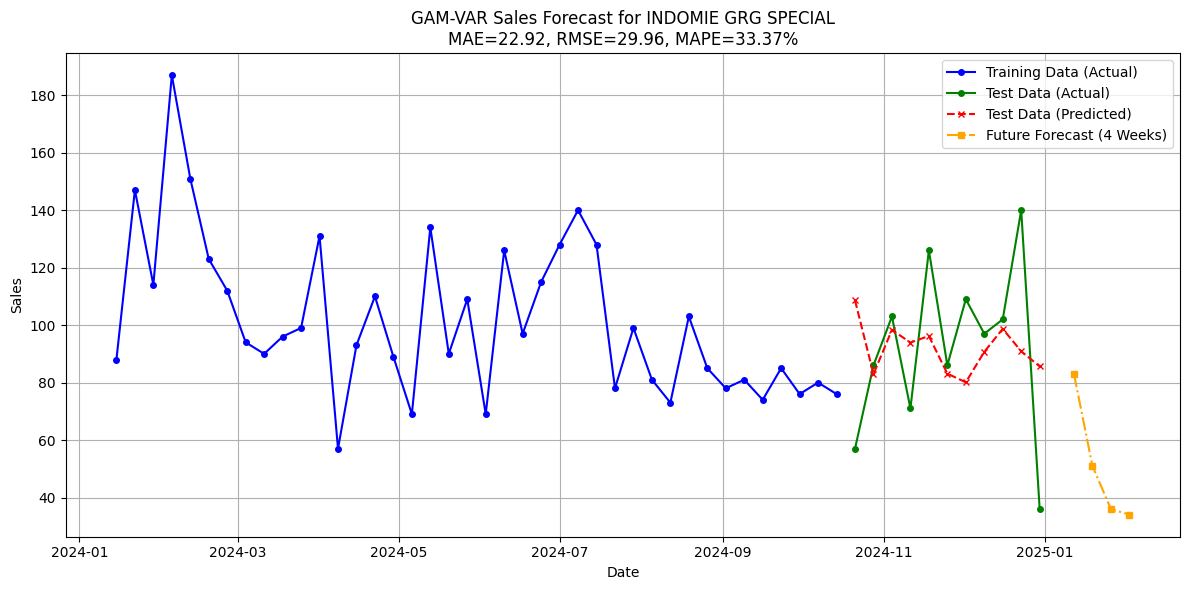


--- Memproses Produk: INDOMILK KID CKL 115ML ---
  - MAE: 21.95
  - RMSE: 25.19
  - MAPE: 44.02%


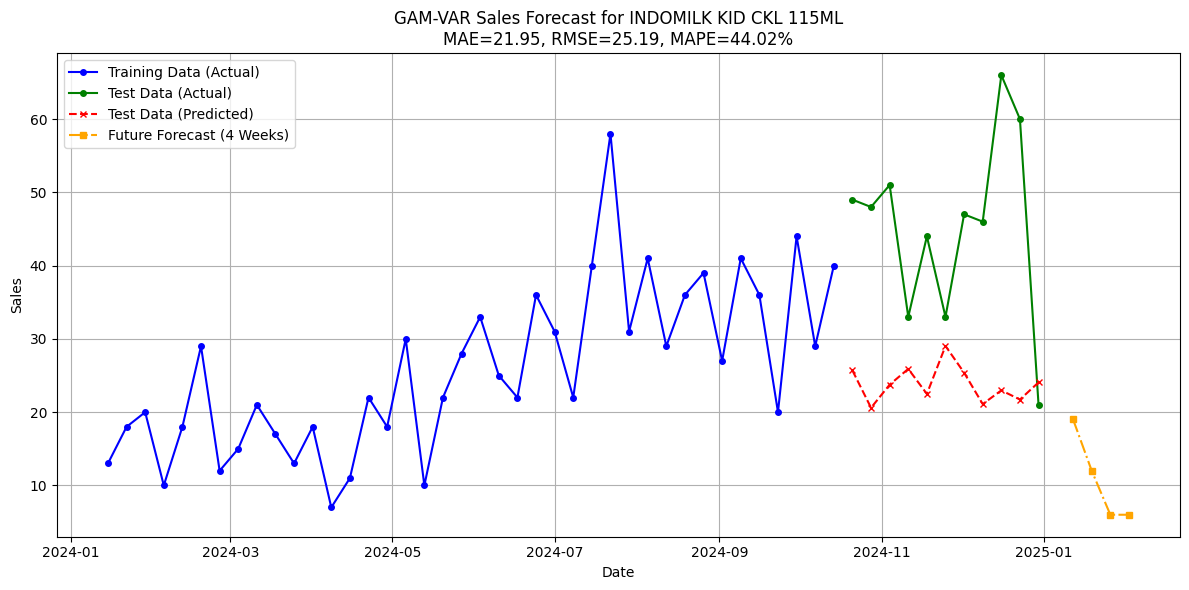


--- Memproses Produk: SEDAAP MIE SOTO ---
  - MAE: 7.27
  - RMSE: 8.42
  - MAPE: 43.21%


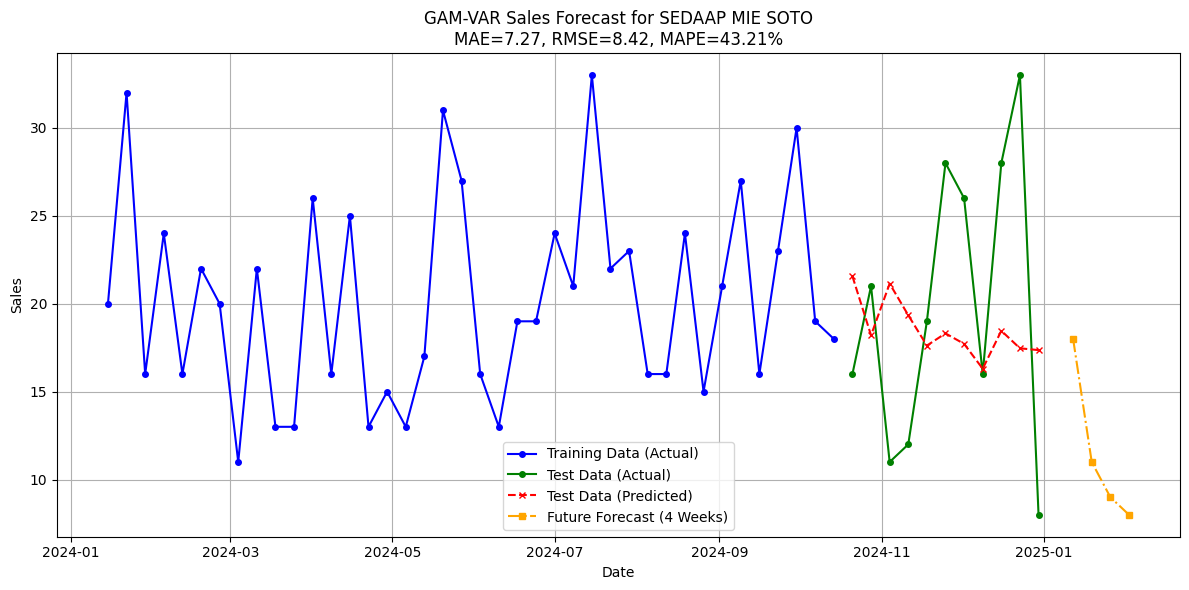


--- Memproses Produk: SAKINAH 1500ML ---
  - MAE: 18.57
  - RMSE: 21.92
  - MAPE: 46.82%


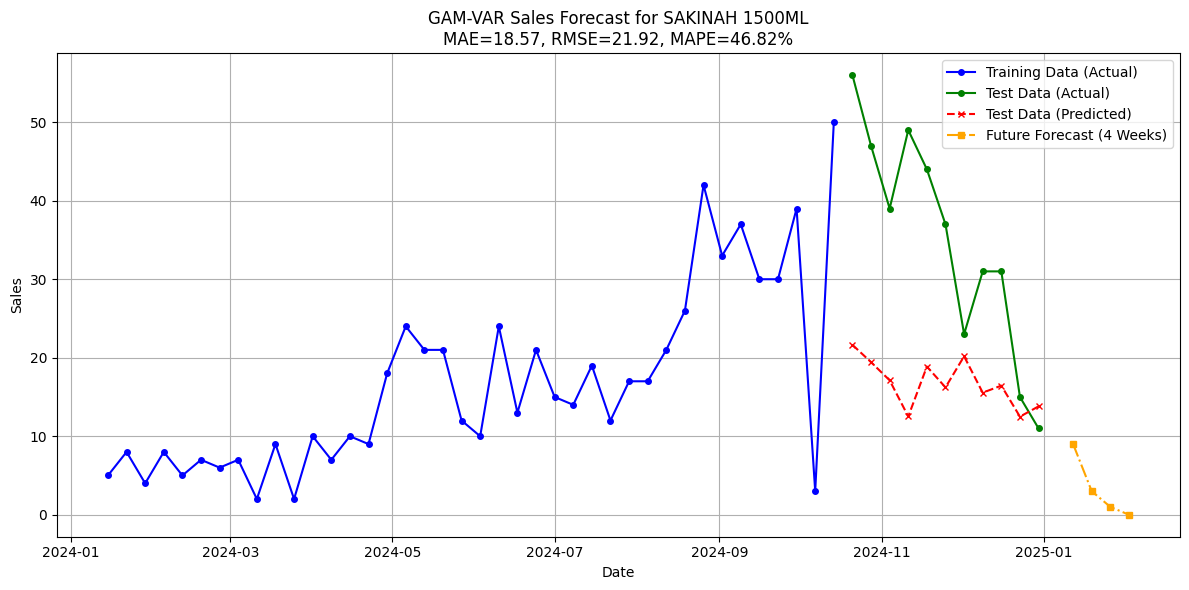


--- Memproses Produk: INDOMILK KID VNL 115ML ---
  - MAE: 8.37
  - RMSE: 10.03
  - MAPE: 138.48%


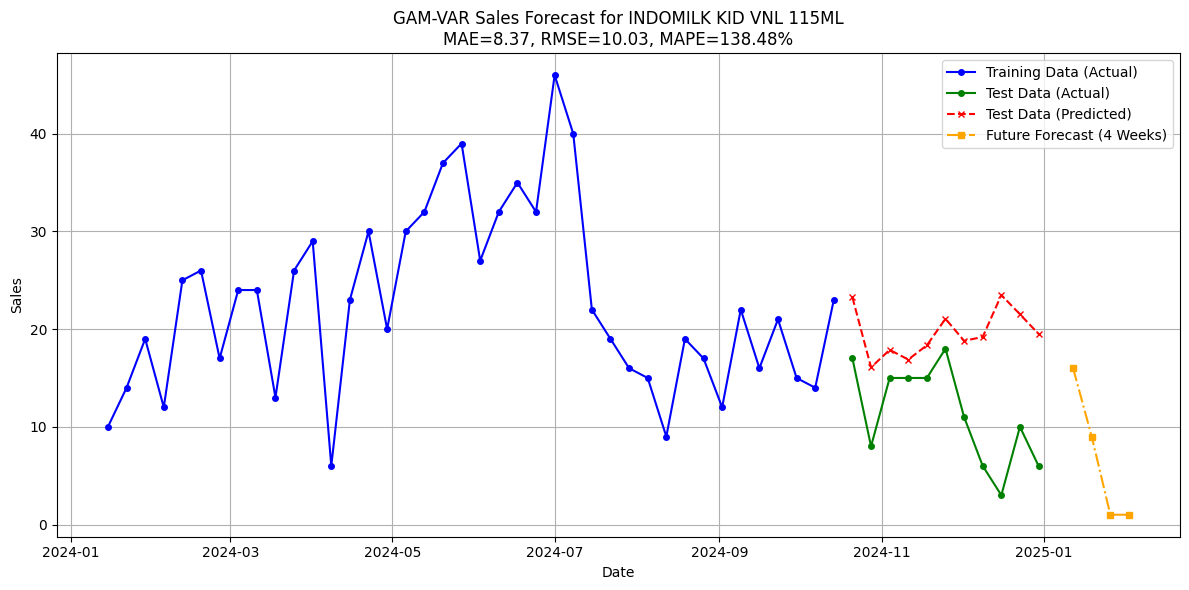


--- Memproses Produk: INDOMILK KID STR 115ML ---
  - MAE: 3.39
  - RMSE: 4.63
  - MAPE: 45.30%


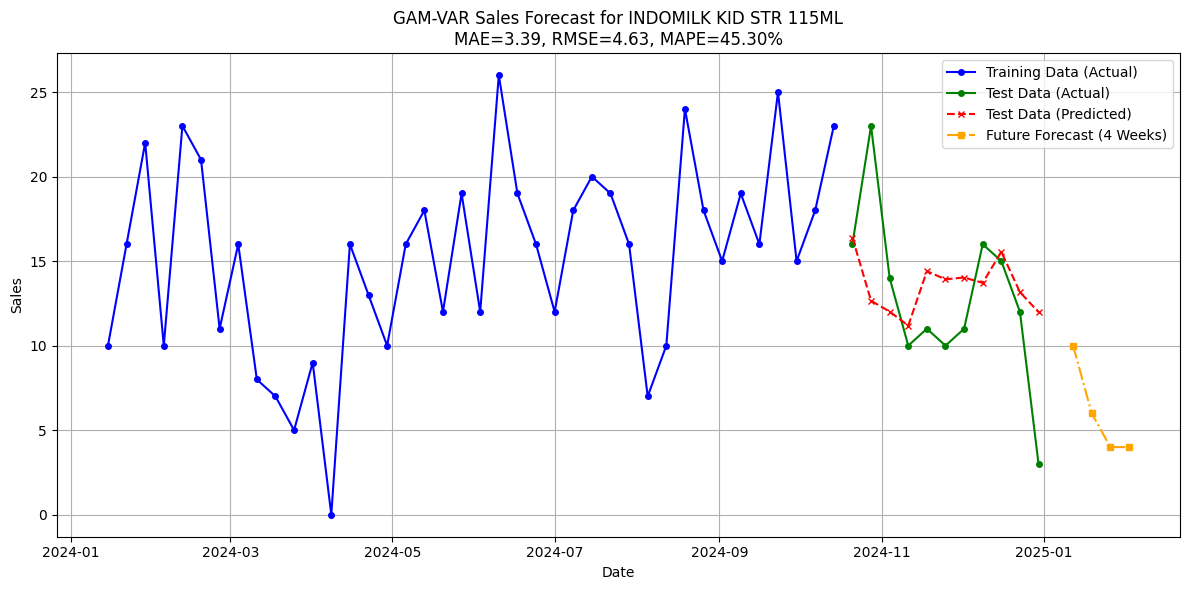


--- Memproses Produk: INDOMIE SOTO MIE ---
  - MAE: 8.58
  - RMSE: 11.00
  - MAPE: 38.62%


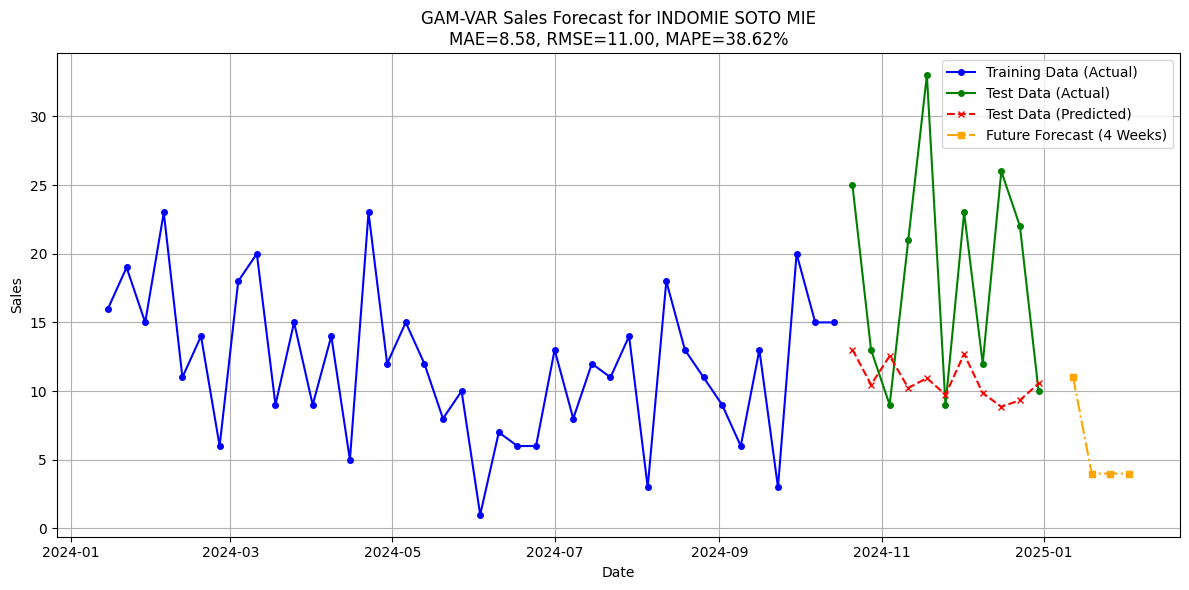


--- Memproses Produk: SEDAAP MIE AYAM BWG ---
  - MAE: 2.06
  - RMSE: 2.45
  - MAPE: 55.91%


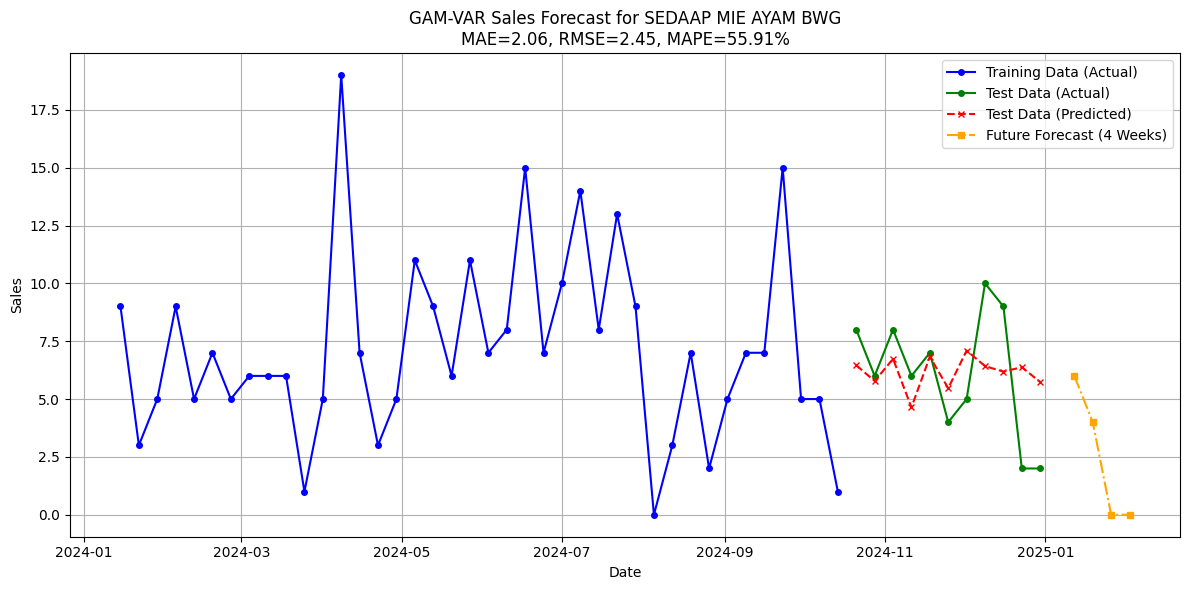


--- Memproses Produk: EKONOMI LIQUID REFF 235ML ---
  - MAE: 3.24
  - RMSE: 3.78
  - MAPE: 85.74%


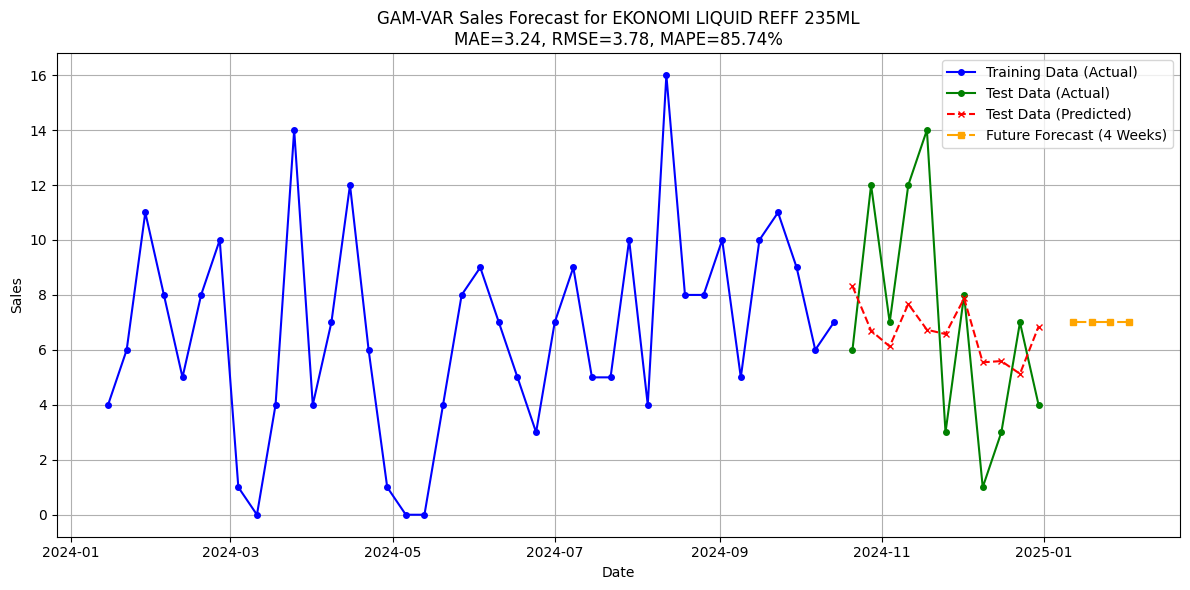


--- Memproses Produk: WALLS CORN B/WHITE 82GR ---
  - MAE: 3.29
  - RMSE: 4.95
  - MAPE: 84.43%


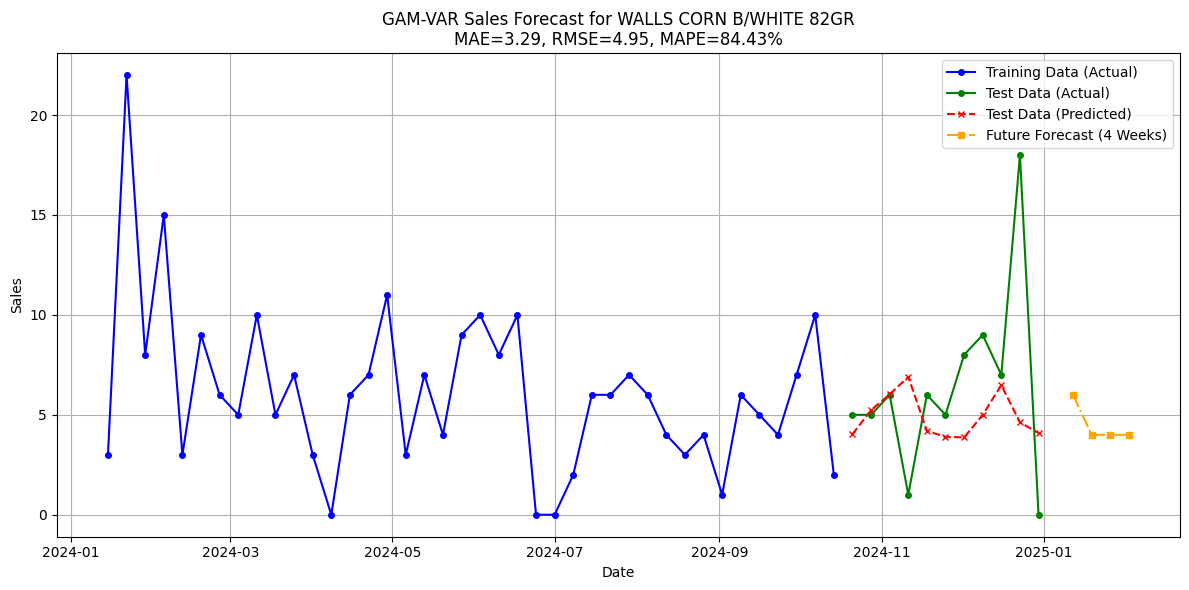


--- Memproses Produk: WALLS POPULAIRE CKL ---
  - MAE: 2.07
  - RMSE: 2.39
  - MAPE: 35.45%


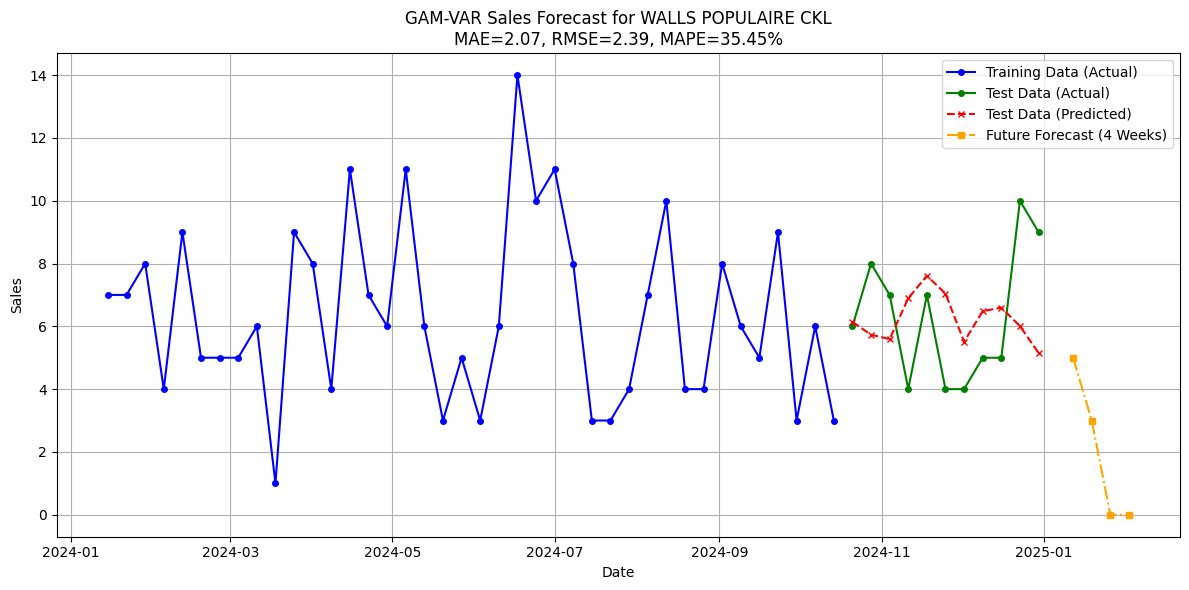


--- Memproses Produk: WALLS POPULAIRE STR ---
  - MAE: 2.56
  - RMSE: 3.13
  - MAPE: 78.42%


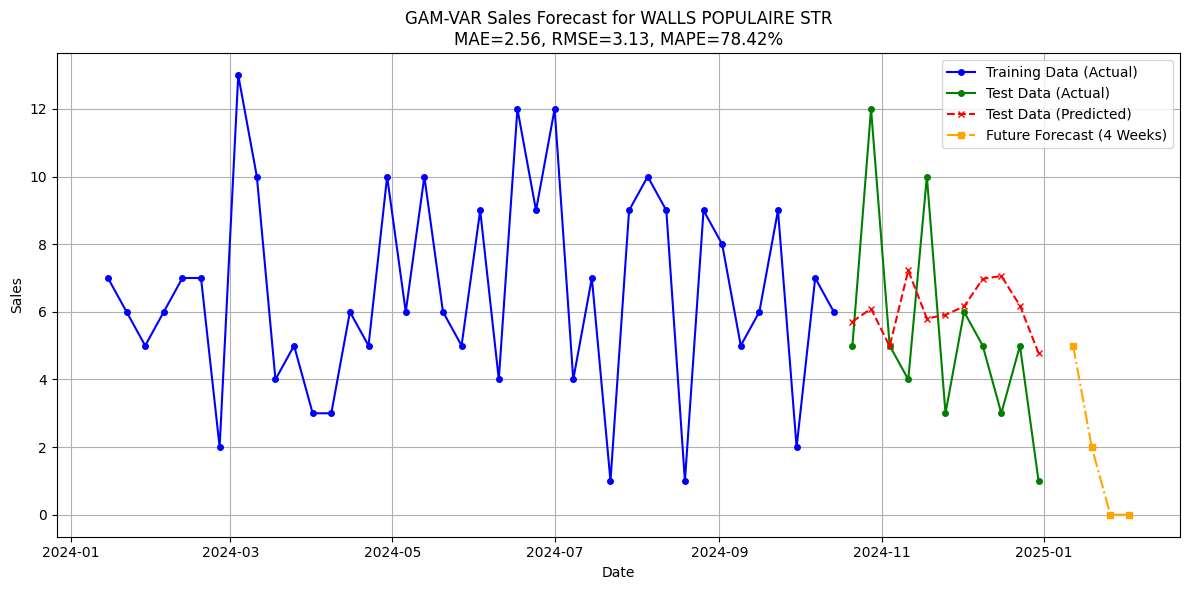


--- Memproses Produk: MAMA LEMON 115ML ---
  - MAE: 2.53
  - RMSE: 2.84
  - MAPE: 81.07%


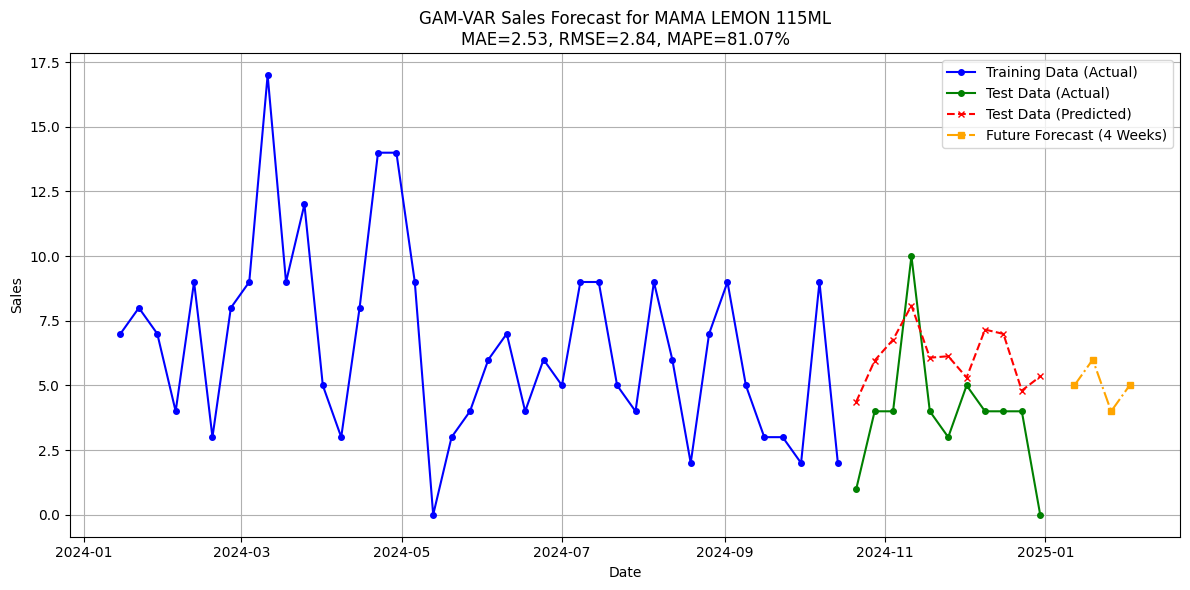


--- Memproses Produk: DELFI TOP CHO 9GR ---
  - MAE: 1.80
  - RMSE: 2.54
  - MAPE: 28.71%


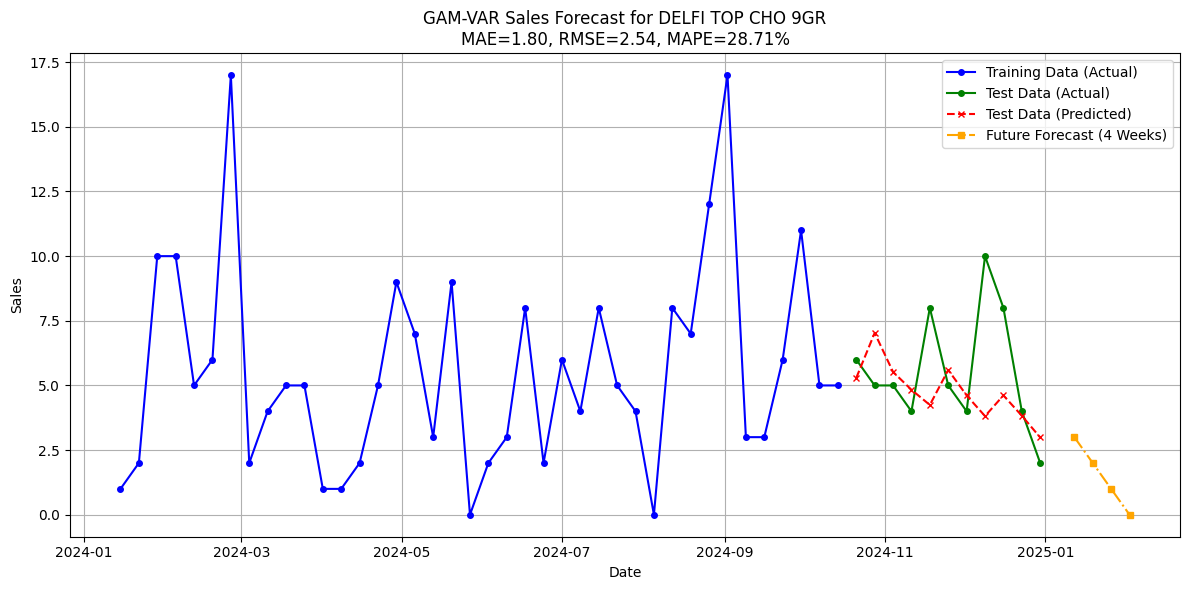


--- Memproses Produk: ROMA KELAPA 300GR ---
  - MAE: 2.81
  - RMSE: 3.56
  - MAPE: 50.11%


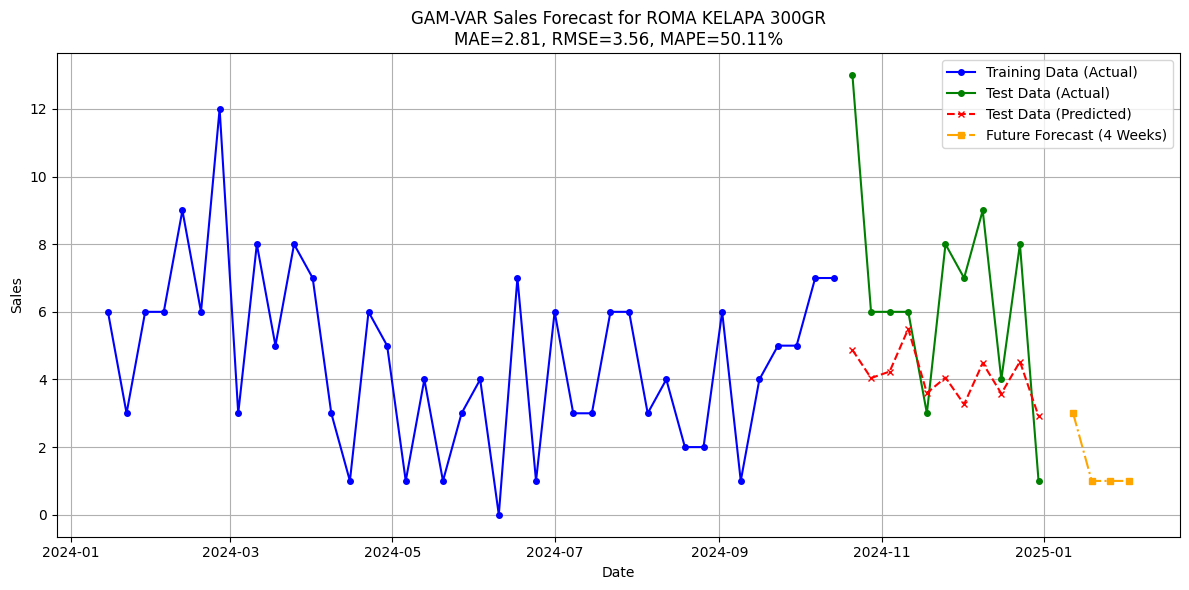


--- Memproses Produk: DELFI TOP B/WHITE 9GR ---
  - MAE: 2.33
  - RMSE: 2.82
  - MAPE: 74.80%


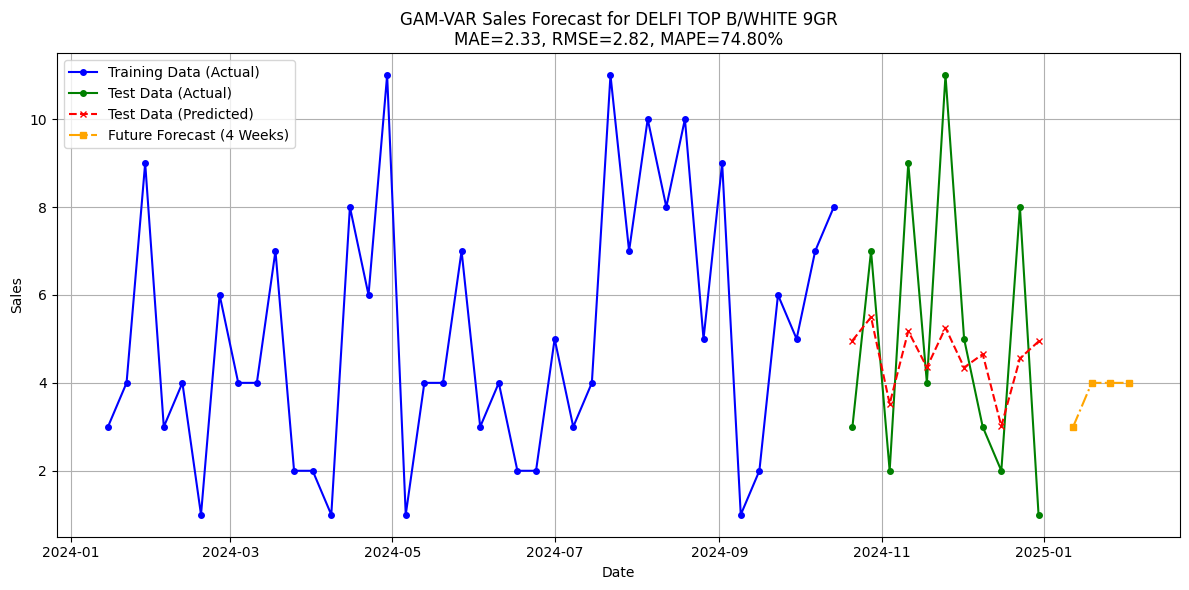


--- Memproses Produk: BISKUAT BOLU CKL 16GR ---
  - MAE: 3.52
  - RMSE: 4.07
  - MAPE: 59.58%


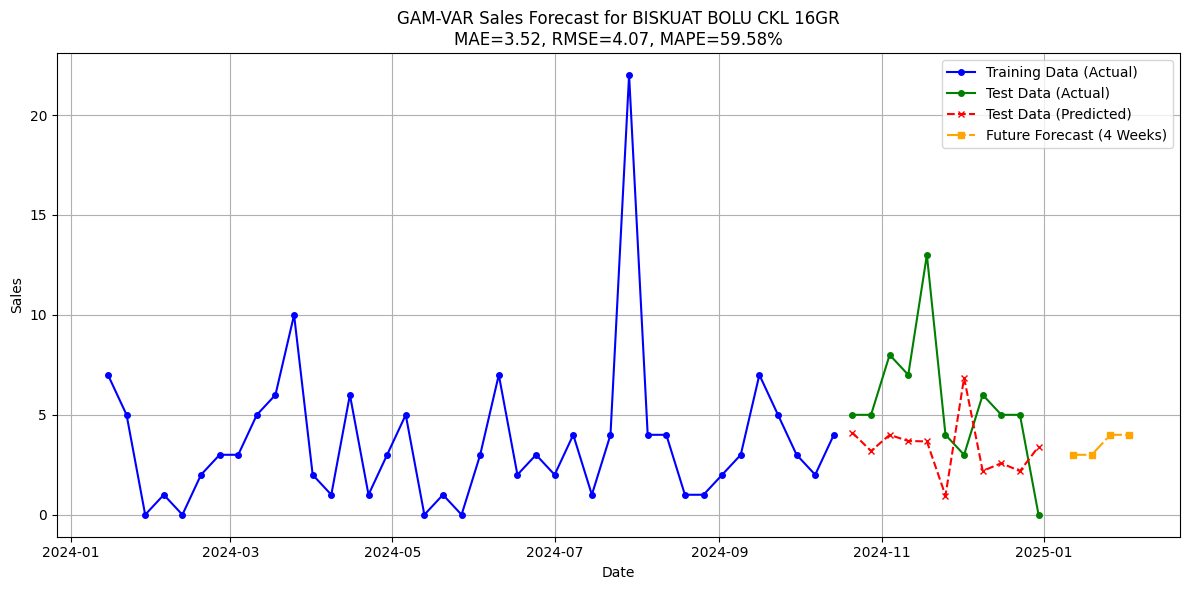


--- Memproses Produk: DELFI TOP STR 9GR ---
  - MAE: 1.99
  - RMSE: 2.26
  - MAPE: 110.19%


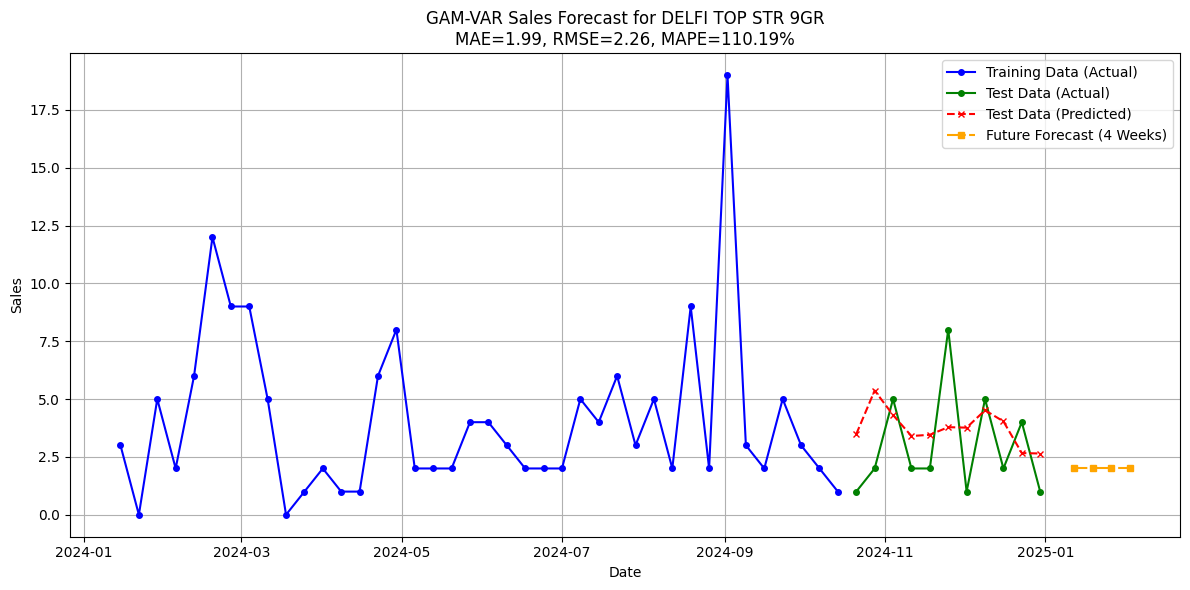



             PROSES FORECASTING DAN EVALUASI SELESAI             

--- Ringkasan Hasil Evaluasi Model (Produk dengan Akurasi Terbaik ke Terjelek) ---
                                 MAE       RMSE        MAPE
DELFI TOP CHO 9GR           1.799353   2.543453   28.710408
INDOMIE GRG SPECIAL        22.924930  29.961124   33.370392
WALLS POPULAIRE CKL         2.071822   2.391714   35.447106
INDOMIE SOTO MIE            8.583201  10.997379   38.617661
SEDAAP MIE SOTO             7.266616   8.420563   43.205716
INDOMILK KID CKL 115ML     21.946918  25.187473   44.017862
INDOMILK KID STR 115ML      3.386079   4.634488   45.302465
SAKINAH 1500ML             18.574175  21.920418   46.821323
ROMA KELAPA 300GR           2.813657   3.559692   50.107363
SEDAAP MIE AYAM BWG         2.056224   2.454143   55.906990
BISKUAT BOLU CKL 16GR       3.517839   4.068989   59.583274
DELFI TOP B/WHITE 9GR       2.328843   2.824973   74.795429
WALLS POPULAIRE STR         2.557154   3.133240   78.418942
MAMA LEM

In [17]:
# --- Fungsi untuk Menghitung Metrik ---
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) > 0:
        mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    else:
        mape = np.nan

    return mae, rmse, mape

# --- Hyperparameter GAM-VAR ---
LOOK_BACK = 2
FORECAST_HORIZON = 4

# --- Persiapan Data untuk GAM-VAR (Versi tanpa fitur waktu tambahan) ---
df_features = df_final.copy()
for col in product_columns:
    for i in range(1, LOOK_BACK + 1):
        df_features[f'{col}_lag{i}'] = df_features[col].shift(i)

df_features.dropna(inplace=True)
X_cols = [col for col in df_features.columns if '_lag' in col] # Hanya kolom lagged

if len(df_features) < LOOK_BACK + 2:
    raise ValueError(f"Data historis terlalu sedikit ({len(df_features)} baris setelah lagging) untuk LOOK_BACK={LOOK_BACK}.")

train_size = int(len(df_features) * 0.8)
X_train = df_features[X_cols].iloc[:train_size]
X_test = df_features[X_cols].iloc[train_size:]

print("="*80)
print("             MEMULAI FORECASTING DENGAN GAM-VAR DAN EVALUASI             ")
print("="*80)
print(f"Total data setelah lagging: {len(df_features)} titik.")
print(f"Ukuran data training (80%): {train_size} titik.")
print(f"Ukuran data testing (20%): {len(X_test)} titik.")
print(f"Jumlah lag (LOOK_BACK): {LOOK_BACK}")
print("\n")

gam_models = {}
evaluation_results = {}
future_forecasts_data_list = []

for product in product_columns:
    print(f"\n--- Memproses Produk: {product} ---")

    y_train = df_features[product].iloc[:train_size]
    y_test_actual = df_features[product].iloc[train_size:]

    # Formula GAM: s(i) untuk setiap fitur (default n_splines=10, lam=0.6)
    formula_terms = [s(i) for i in range(X_train.shape[1])]
    
    # Pastikan formula_terms tidak kosong
    if not formula_terms:
        print(f"  Warning: No formula terms created for {product}. Skipping model fitting.")
        evaluation_results[product] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
        future_forecasts_data_list.append(np.full(FORECAST_HORIZON, np.nan))
        continue

    formula = formula_terms[0]
    for term in formula_terms[1:]:
        formula += term

    try:
        # Model GAM menggunakan default pyGAM untuk n_splines dan lam
        gam = LinearGAM(formula, fit_intercept=True)
        gam.fit(X_train.values, y_train.values)
        gam_models[product] = gam

        y_pred = gam.predict(X_test.values)
        y_pred[y_pred < 0] = 0

        mae, rmse, mape = calculate_metrics(y_test_actual.values, y_pred)

        print(f"  - MAE: {mae:.2f}")
        print(f"  - RMSE: {rmse:.2f}")
        if pd.isna(mape):
            print(f"  - MAPE: N/A (Semua nilai aktual adalah 0 di periode testing)")
        else:
            print(f"  - MAPE: {mape:.2f}%")

        evaluation_results[product] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

        # --- Prediksi Masa Depan (Recursive/Iterative Forecasting) ---
        product_future_forecast_unscaled = []
        # current_recursive_data hanya berisi data produk, tidak ada fitur waktu
        current_recursive_data = df_final[product_columns].tail(LOOK_BACK).values.copy()

        for k in range(FORECAST_HORIZON):
            X_input_k = []
            for col_name in product_columns:
                for lag_num in range(1, LOOK_BACK + 1):
                    val = current_recursive_data[LOOK_BACK - lag_num, product_columns.index(col_name)]
                    X_input_k.append(val)
            
            X_input_k = np.array(X_input_k).reshape(1, -1)

            predicted_val = gam.predict(X_input_k)[0]
            predicted_val = max(0, round(predicted_val))

            product_future_forecast_unscaled.append(predicted_val)

            new_row_for_recursive_data = np.zeros((1, len(product_columns)))
            new_row_for_recursive_data[0, product_columns.index(product)] = predicted_val
            current_recursive_data = np.concatenate((current_recursive_data[1:], new_row_for_recursive_data), axis=0)

        future_forecasts_data_list.append(np.array(product_future_forecast_unscaled))

        # --- Visualisasi ---
        plt.figure(figsize=(12, 6))
        
        plot_dates_df_features = df_features['TANGGAL']

        plt.plot(plot_dates_df_features.iloc[:train_size], df_features[product].iloc[:train_size],
                 label='Training Data (Actual)', color='blue', marker='o', markersize=4, linestyle='-')
        
        plt.plot(plot_dates_df_features.iloc[train_size:], df_features[product].iloc[train_size:],
                 label='Test Data (Actual)', color='green', marker='o', markersize=4, linestyle='-')
        
        plt.plot(plot_dates_df_features.iloc[train_size:], y_pred,
                 label='Test Data (Predicted)', color='red', marker='x', markersize=4, linestyle='--')
        
        future_plot_dates = pd.date_range(start=df_final['TANGGAL'].iloc[-1] + pd.Timedelta(weeks=1),
                                          periods=FORECAST_HORIZON, freq='W')
        plt.plot(future_plot_dates, product_future_forecast_unscaled,
                 label=f'Future Forecast ({FORECAST_HORIZON} Weeks)', color='orange', marker='s', markersize=4, linestyle='-.')
        
        plt.title(f'GAM-VAR Sales Forecast for {product}\nMAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"  Gagal melatih atau memprediksi GAM untuk {product}: {e}")
        evaluation_results[product] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
        future_forecasts_data_list.append(np.full(FORECAST_HORIZON, np.nan))


# Buat DataFrame untuk prediksi masa depan (setelah semua loop selesai)
last_historical_date_actual_df = df_final['TANGGAL'].iloc[-1]
future_dates_df_index = pd.date_range(start=last_historical_date_actual_df + pd.Timedelta(weeks=1), periods=FORECAST_HORIZON, freq='W')
future_forecasts_df = pd.DataFrame(np.array(future_forecasts_data_list).T, columns=product_columns, index=future_dates_df_index)
future_forecasts_df.index.name = 'TANGGAL'


print("\n")
print("="*80)
print("             PROSES FORECASTING DAN EVALUASI SELESAI             ")
print("="*80)

# --- 4. Ringkasan Hasil Evaluasi dan Prediksi ---
print("\n--- Ringkasan Hasil Evaluasi Model (Produk dengan Akurasi Terbaik ke Terjelek) ---")

eval_df_summary = pd.DataFrame.from_dict(evaluation_results, orient='index')

# Urutkan DataFrame berdasarkan akurasi (MAPE terendah, lalu MAE terendah)
eval_df_summary_sorted = eval_df_summary.sort_values(by=['MAPE', 'MAE'], ascending=True)

# Tampilkan DataFrame yang sudah terurut
print(eval_df_summary_sorted.to_string())

# --- Tambahkan Ringkasan Metrik Keseluruhan di sini ---
print("\n--- Performa Model Keseluruhan (Rata-rata Lintas Produk) ---")
overall_mae = eval_df_summary_sorted['MAE'].mean()
overall_rmse = eval_df_summary_sorted['RMSE'].mean()
overall_mape = eval_df_summary_sorted['MAPE'].mean()

print(f"Average MAE:  {overall_mae:.2f}")
print(f"Average RMSE: {overall_rmse:.2f}")
if pd.isna(overall_mape):
    print("Average MAPE: N/A (Satu atau lebih produk memiliki semua nilai aktual nol di test set)")
else:
    print(f"Average MAPE: {overall_mape:.2f}%")
# --- Akhir Penambahan ---

print(f"\n--- Prediksi Penjualan untuk {FORECAST_HORIZON} Minggu Ke Depan ---")
print(future_forecasts_df.to_string())

print("\n--- Catatan Penting ---")
print("1. Akurasi model sangat terbatas karena jumlah data historis yang sangat sedikit (53 titik).")
print("2. 'MAPE: N/A' menunjukkan bahwa semua nilai aktual di periode testing adalah 0.")
print("3. Model GAM-VAR di sini adalah implementasi 'GAM per produk dengan fitur VAR-like'.")
print("4. Performa model GAM sangat bergantung pada tuning parameter s() dan lam.")
print("5. Untuk hasil yang lebih andal, diperlukan data historis yang JAUH lebih banyak (minimal beberapa tahun).")